# <font color='red'>**Sequence to sequence implementation**</font>

1. Download the **Italian** to **English** translation dataset from <a href="http://www.manythings.org/anki/ita-eng.zip">here</a>

2. You will find **ita.txt** file in that ZIP, 
you can read that data using python and preprocess that data this way only: 
<img src='https://i.imgur.com/z0j79Jf.png'>    
    
3. Implement a simple Encoder and Decoder architecture  

4.  BLEU score as metric to evaluate your model.

5. Use Tensorboard to plot the Graph, Scores and histograms of gradients. 

    



In [1]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
from tensorflow.keras.layers import TimeDistributed
tf.keras.backend.clear_session()
from tensorflow.keras.layers import Input, Softmax, RNN, Dense, Embedding, LSTM
from tensorflow.keras.models import Model
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import warnings
warnings.filterwarnings("ignore")


<font color='blue'>**Load the data**</font>

In [2]:
!wget http://www.manythings.org/anki/ita-eng.zip


--2023-01-24 12:06:58--  http://www.manythings.org/anki/ita-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7882203 (7.5M) [application/zip]
Saving to: ‘ita-eng.zip’

ita-eng.zip         100%[===================>]   7.52M  6.42MB/s    in 1.2s    

2023-01-24 12:07:00 (6.42 MB/s) - ‘ita-eng.zip’ saved [7882203/7882203]



In [3]:
!unzip ita-eng.zip

Archive:  ita-eng.zip
  inflating: ita.txt                 
  inflating: _about.txt              


<font color='blue'>**Preprocess data**</font>

In [4]:
!wget https://www.dropbox.com/s/ddkmtqz01jc024u/glove.6B.100d.txt

--2023-01-24 12:08:05--  https://www.dropbox.com/s/ddkmtqz01jc024u/glove.6B.100d.txt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.9.18, 2620:100:601f:18::a27d:912
Connecting to www.dropbox.com (www.dropbox.com)|162.125.9.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/ddkmtqz01jc024u/glove.6B.100d.txt [following]
--2023-01-24 12:08:06--  https://www.dropbox.com/s/raw/ddkmtqz01jc024u/glove.6B.100d.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc06ebfdd2bf037f97d3ff634656.dl.dropboxusercontent.com/cd/0/inline/B1LTVHkvIsIdpuJpK4J2ecQd8GxzCOVE3QzLi9RSKQNw4v7Xa1jzbhoK1du68V7Di5Ok17R00XzXibZCKTisEy1jmshtSktaiyJF-S8lMVoLGTFgeyNc99TEIqYbb24KAWqj6j1UaLL4_ajI12n-LEBu8utbg_KUQhRtJ4qGxGnxUw/file# [following]
--2023-01-24 12:08:07--  https://uc06ebfdd2bf037f97d3ff634656.dl.dropboxusercontent.com/cd/0/inline/B1LTVHkvIsIdpuJpK4J2ecQd8GxzCOVE3QzLi9RSKQNw4v7Xa1jzbhoK1du68V7Di

In [5]:
with open('ita.txt', 'r', encoding="utf8") as f:
    eng=[]
    ita=[]
    for i in f.readlines():
        eng.append(i.split("\t")[0])
        ita.append(i.split("\t")[1])
data = pd.DataFrame(data=list(zip(eng, ita)), columns=['english','italian'])
print(data.shape)
data.head()

(358373, 2)


,english,italian
0,Hi.,Ciao!
1,Hi.,Ciao.
2,Run!,Corri!
3,Run!,Corra!
4,Run!,Correte!


In [6]:
def decontractions(phrase):
    """decontracted takes text and convert contractions into natural form.
     ref: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490"""
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"won\’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    phrase = re.sub(r"n\’t", " not", phrase)
    phrase = re.sub(r"\’re", " are", phrase)
    phrase = re.sub(r"\’s", " is", phrase)
    phrase = re.sub(r"\’d", " would", phrase)
    phrase = re.sub(r"\’ll", " will", phrase)
    phrase = re.sub(r"\’t", " not", phrase)
    phrase = re.sub(r"\’ve", " have", phrase)
    phrase = re.sub(r"\’m", " am", phrase)

    return phrase

def preprocess(text):
    # convert all the text into lower letters
    # use this function to remove the contractions: https://gist.github.com/anandborad/d410a49a493b56dace4f814ab5325bbd
    # remove all the spacial characters: except space ' '
    text = text.lower()
    text = decontractions(text)
    text = re.sub('[^A-Za-z0-9 ]+', '', text)
    return text

def preprocess_ita(text):
    # convert all the text into lower letters
    # remove the words betweent brakets ()
    # remove these characters: {'$', ')', '?', '"', '’', '.',  '°', '!', ';', '/', "'", '€', '%', ':', ',', '('}
    # replace these spl characters with space: '\u200b', '\xa0', '-', '/'
    # I have found these characters after observing the data points, feel free to explore more and see if you can do find more
    # you are free to do more proprocessing
    # note that the model will learn better with better preprocessed data 
    
    text = text.lower()
    text = decontractions(text)
    text = re.sub('[$)\?"’.°!;\'€%:,(/]', '', text)
    text = re.sub('\u200b', ' ', text)
    text = re.sub('\xa0', ' ', text)
    text = re.sub('-', ' ', text)
    return text


data['english'] = data['english'].apply(preprocess)
data['italian'] = data['italian'].apply(preprocess_ita)
data.head()

,english,italian
0,hi,ciao
1,hi,ciao
2,run,corri
3,run,corra
4,run,correte


In [7]:
data['italian_len'] = data['italian'].str.split().apply(len)
data = data[data['italian_len'] < 20]

data['english_len'] = data['english'].str.split().apply(len)
data = data[data['english_len'] < 20]

data['english_inp'] = '<start> ' + data['english'].astype(str)
data['english_out'] = data['english'].astype(str) + ' <end>'

data = data.drop(['english','italian_len','english_len'], axis=1)
# only for the first sentance add a toke <end> so that we will have <end> in tokenizer
data.head()

,italian,english_inp,english_out
0,ciao,<start> hi,hi <end>
1,ciao,<start> hi,hi <end>
2,corri,<start> run,run <end>
3,corra,<start> run,run <end>
4,correte,<start> run,run <end>


In [8]:
data.sample(10)

,italian,english_inp,english_out
214463,unape volò fuori dalla finestra,<start> a bee flew out of the window,a bee flew out of the window <end>
221718,fammi sapere il tuo nuovo indirizzo,<start> let me know your new address,let me know your new address <end>
97099,tom ha finito il lavoro,<start> tom finished the job,tom finished the job <end>
357118,tom ha comprato una macchina fotografica un pa...,<start> tom bought a camera just a couple of d...,tom bought a camera just a couple of days ago ...
130557,noi conoscevamo entrambi i rischi,<start> we both knew the risks,we both knew the risks <end>
114140,tom viveva qui,<start> tom used to live here,tom used to live here <end>
186275,ho sentito che è venuta qui,<start> i heard that she came here,i heard that she came here <end>
341221,pensavo che sarei arrivata qui prima di voi,<start> i thought i was going to get here befo...,i thought i was going to get here before you <...
22618,tom sta canticchiando,<start> tom is humming,tom is humming <end>
279973,voi siete superficiali e materialisti,<start> you are shallow and materialistic,you are shallow and materialistic <end>


In [9]:
from sklearn.model_selection import train_test_split
train, validation = train_test_split(data, test_size=0.2)

In [10]:
print(train.shape, validation.shape)

(286292, 3) (71574, 3)


In [11]:

# for one sentence I will be adding <end> token so that the tokanizer learns the word <end>
# with this I can use only one tokenizer for both encoder output and decoder output
train.iloc[0]['english_inp']= str(train.iloc[0]['english_inp'])+' <end>'
train.iloc[0]['english_out']= str(train.iloc[0]['english_out'])+' <end>'

In [12]:
train.head(10)

,italian,english_inp,english_out
169218,come vorreste pagare,<start> how would you like to pay <end>,how would you like to pay <end> <end>
133514,voi non siete male in questo,<start> you are not bad at this,you are not bad at this <end>
281720,suo fratello va a scuola in autobus,<start> her brother goes to school by bus,her brother goes to school by bus <end>
157073,sono così felice che voi siate qui,<start> i am so happy you are here,i am so happy you are here <end>
219338,non mi sarei dovuta fidare di tom,<start> i should not have trusted tom,i should not have trusted tom <end>
152154,mi diede diversi libri,<start> he gave me several books,he gave me several books <end>
118314,potete portarmi da tom,<start> can you take me to tom,can you take me to tom <end>
222387,in questo momento la gente è spaventata,<start> right now people are scared,right now people are scared <end>
328200,fece del duro lavoro manuale durante il giorno,<start> he did hard manual labor through the day,he did hard manual labor through the day <end>
95552,mi ha aiutata molto,<start> that helped me a lot,that helped me a lot <end>


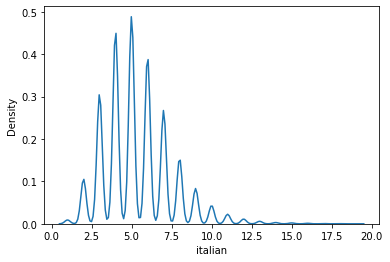

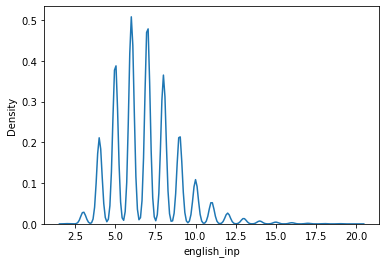

In [13]:
ita_lengths = train['italian'].str.split().apply(len)
eng_lengths = train['english_inp'].str.split().apply(len)
import seaborn as sns
sns.kdeplot(ita_lengths)
plt.show()
sns.kdeplot(eng_lengths)
plt.show()

## <font color='blue'>**Implement custom encoder decoder**</font>

<font color='blue'>**Encoder**</font>

In [14]:
tknizer_ita = Tokenizer()
tknizer_ita.fit_on_texts(train['italian'].values)
tknizer_eng = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
tknizer_eng.fit_on_texts(train['english_inp'].values)

In [15]:
vocab_size_eng=len(tknizer_eng.word_index.keys())
print(vocab_size_eng)
vocab_size_ita=len(tknizer_ita.word_index.keys())
print(vocab_size_ita)

13180
26768


In [16]:
tknizer_eng.word_index['<start>'], tknizer_eng.word_index['<end>']

(1, 10409)

In [17]:
embeddings_index = dict()
f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

embedding_matrix = np.zeros((vocab_size_eng+1, 100))
for word, i in tknizer_eng.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [18]:
class Encoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns encoder-outputs,encoder_final_state_h,encoder_final_state_c
    '''

    def __init__(self, inp_vocab_size, embedding_size, lstm_size, input_length):
        super().__init__()
        self.vocab_size = inp_vocab_size
        self.embedding_dim = embedding_size
        self.lstm_size = lstm_size
        self.input_length = input_length
        self.lstm_output = 0
        self.lstm_state_h=0
        self.lstm_state_c=0

    def build(self, input_shape):
        self.embedding = Embedding(input_dim=self.vocab_size, output_dim=self.embedding_dim, input_length=self.input_length,
                           mask_zero=True, name="embedding_layer_encoder")
        self.lstm = LSTM(self.lstm_size, return_state=True, return_sequences=True, name="Encoder_LSTM")
    
    def call(self,input_sentances, states):
        '''
          This function takes a sequence input and the initial states of the encoder.
          Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to encoder_lstm
          returns -- encoder_output, last time step's hidden and cell state
        '''
        input_embedd = self.embedding(input_sentances)
        self.lstm_output, self.lstm_state_h,self.lstm_state_c = self.lstm(input_embedd)
        
        return self.lstm_output, self.lstm_state_h, self.lstm_state_c

      

    
    def initialize_states(self,batch_size):
        '''
        Given a batch size it will return intial hidden state and intial cell state.
        If batch size is 32- Hidden state is zeros of size [32,lstm_units], cell state zeros is of size [32,lstm_units]
        '''
        dim1 = tf.zeros(shape=[batch_size,self.lstm_size])
        dim2 = tf.zeros(shape=[batch_size,self.lstm_size])

        return [dim1, dim2]

<font color='orange'>**Grader function - 1**</font>

In [19]:
def grader_check_encoder():
    '''
        vocab-size: Unique words of the input language,
        embedding_size: output embedding dimension for each word after embedding layer,
        lstm_size: Number of lstm units,
        input_length: Length of the input sentence,
        batch_size
    '''
    vocab_size=10
    embedding_size=20
    lstm_size=32
    input_length=10
    batch_size=16
    #Intialzing encoder 
    encoder=Encoder(vocab_size,embedding_size,lstm_size,input_length)
    input_sequence=tf.random.uniform(shape=[batch_size,input_length],maxval=vocab_size,minval=0,dtype=tf.int32)
    #Intializing encoder initial states
    initial_state=encoder.initialize_states(batch_size)
    
    encoder_output,state_h,state_c=encoder(input_sequence,initial_state)
    
    assert(encoder_output.shape==(batch_size,input_length,lstm_size) and state_h.shape==(batch_size,lstm_size) and state_c.shape==(batch_size,lstm_size))
    return True
print(grader_check_encoder())

2023-01-24 12:09:19.137895: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-24 12:09:19.226777: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-24 12:09:19.227544: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-24 12:09:19.229290: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

True


In [20]:
class Decoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns output sequence
    '''

    def __init__(self, out_vocab_size, embedding_dim, lstm_size, input_length):
        super().__init__()
        self.vocab_size = out_vocab_size
        self.embedding_dim = 100
        self.dec_units = lstm_size
        self.input_length = input_length
        # we are using embedding_matrix and not training the embedding layer
        self.embedding = Embedding(input_dim=self.vocab_size, output_dim=self.embedding_dim, input_length=self.input_length,
                           mask_zero=True, name="embedding_layer_decoder")
        self.lstm = LSTM(self.dec_units, return_sequences=True, return_state=True, name="Encoder_LSTM")
        


    def call(self, target_sentances, initial_state):
        '''
          This function takes a sequence input and the initial states of the encoder.
          Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to decoder_lstm
        '''
        target_embedd = self.embedding(target_sentances)
        lstm_output, _,_ = self.lstm(target_embedd, initial_state)

        return lstm_output, _, _

<font color='orange'>**Grader function - 2**</font>

In [21]:
def grader_decoder():
    '''
        out_vocab_size: Unique words of the target language,
        embedding_size: output embedding dimension for each word after embedding layer,
        dec_units: Number of lstm units in decoder,
        input_length: Length of the input sentence,
        batch_size
        
    
    '''
    out_vocab_size=13 
    embedding_dim=12 
    input_length=10
    dec_units=16 
    batch_size=32
    
    target_sentences=tf.random.uniform(shape=(batch_size,input_length),maxval=10,minval=0,dtype=tf.int32)
    encoder_output=tf.random.uniform(shape=[batch_size,input_length,dec_units])
    state_h=tf.random.uniform(shape=[batch_size,dec_units])
    state_c=tf.random.uniform(shape=[batch_size,dec_units])
    states=[state_h,state_c]
    decoder=Decoder(out_vocab_size, embedding_dim, dec_units,input_length )
    output,_,_=decoder(target_sentences, states)
    assert(output.shape==(batch_size,input_length,dec_units))
    return True
print(grader_decoder())

True


In [22]:
class Encoder_decoder(tf.keras.Model):
    
    def __init__(self, encoder_inputs_length, decoder_inputs_length, output_vocab_size, batch_size):
        super().__init__() # https://stackoverflow.com/a/27134600/4084039
        self.encoder = Encoder(inp_vocab_size=vocab_size_ita+1, embedding_size=50, input_length=encoder_inputs_length, lstm_size=256)
        self.decoder = Decoder(out_vocab_size=vocab_size_eng+1, embedding_dim=100, input_length=decoder_inputs_length, lstm_size=256)
        self.dense   = Dense(output_vocab_size, activation='softmax')
        self.initial_state = self.encoder.initialize_states(batch_size)


    
    def call(self,data):
        '''
        A. Pass the input sequence to Encoder layer -- Return encoder_output,encoder_final_state_h,encoder_final_state_c
        B. Pass the target sequence to Decoder layer with intial states as encoder_final_state_h,encoder_final_state_C
        C. Pass the decoder_outputs into Dense layer 
        
        Return decoder_outputs
        '''
        input,output = data[0], data[1]
        encoder_output, encoder_h, encoder_c = self.encoder(input, self.initial_state)
        decoder_output, decoder_h, decoder_c = self.decoder(output, [encoder_h, encoder_c])
        output = self.dense(decoder_output)
        
        return output
        

In [23]:
class Dataset:
    def __init__(self, data, tknizer_ita, tknizer_eng, max_len):
        self.encoder_inps = data['italian'].values
        self.decoder_inps = data['english_inp'].values
        self.decoder_outs = data['english_out'].values
        self.tknizer_eng = tknizer_eng
        self.tknizer_ita = tknizer_ita
        self.max_len = max_len

    def __getitem__(self, i):
        self.encoder_seq = self.tknizer_ita.texts_to_sequences([self.encoder_inps[i]]) # need to pass list of values
        self.decoder_inp_seq = self.tknizer_eng.texts_to_sequences([self.decoder_inps[i]])
        self.decoder_out_seq = self.tknizer_eng.texts_to_sequences([self.decoder_outs[i]])

        self.encoder_seq = pad_sequences(self.encoder_seq, maxlen=self.max_len, dtype='int32', padding='post')
        self.decoder_inp_seq = pad_sequences(self.decoder_inp_seq, maxlen=self.max_len, dtype='int32', padding='post')
        self.decoder_out_seq = pad_sequences(self.decoder_out_seq, maxlen=self.max_len, dtype='int32', padding='post')
        return self.encoder_seq, self.decoder_inp_seq, self.decoder_out_seq

    def __len__(self): # your model.fit_gen requires this function
        return len(self.encoder_inps)

    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.dataset.encoder_inps))


    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        batch = [np.squeeze(np.stack(samples, axis=1), axis=0) for samples in zip(*data)]
        # we are creating data like ([italian, english_inp], english_out) these are already converted into seq
        return tuple([[batch[0],batch[1]],batch[2]])

    def __len__(self):  # your model.fit_gen requires this function
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.random.permutation(self.indexes)


In [24]:
train_dataset = Dataset(train, tknizer_ita, tknizer_eng, 20)
test_dataset  = Dataset(validation, tknizer_ita, tknizer_eng, 20)

train_dataloader = Dataloder(train_dataset, batch_size=1024)
test_dataloader = Dataloder(test_dataset, batch_size=1024)


print(train_dataloader[0][0][0].shape, train_dataloader[0][0][1].shape, train_dataloader[0][1].shape)

(1024, 20) (1024, 20) (1024, 20)


In [25]:
model  = Encoder_decoder(encoder_inputs_length=20, decoder_inputs_length=20, output_vocab_size=vocab_size_eng, batch_size=1024)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy')

train_steps=train.shape[0]//1024
valid_steps=validation.shape[0]//1024

model.fit(train_dataloader, steps_per_epoch=train_steps, epochs=30, validation_data=train_dataloader, validation_steps=valid_steps)

2023-01-24 12:09:44.650348: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005
2023-01-24 12:09:44.995014: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30
279/279 [==============================] - 56s 177ms/step - loss: 1.8417 - val_loss: 1.6134
Epoch 2/30
279/279 [==============================] - 48s 172ms/step - loss: 1.5026 - val_loss: 1.3806
Epoch 3/30
279/279 [==============================] - 49s 176ms/step - loss: 1.2915 - val_loss: 1.2044
Epoch 4/30
279/279 [==============================] - 48s 172ms/step - loss: 1.1393 - val_loss: 1.0623
Epoch 5/30
279/279 [==============================] - 46s 164ms/step - loss: 1.0137 - val_loss: 0.9517
Epoch 6/30
279/279 [==============================] - 48s 172ms/step - loss: 0.9110 - val_loss: 0.8543
Epoch 7/30
279/279 [==============================] - 46s 164ms/step - loss: 0.8237 - val_loss: 0.7725
Epoch 8/30
279/279 [==============================] - 48s 172ms/step - loss: 0.7482 - val_loss: 0.7016
Epoch 9/30
279/279 [==============================] - 48s 171ms/step - loss: 0.6789 - val_loss: 0.6330
Epoch 10/30
279/279 [==============================] - 48s 171ms/step - l

In [26]:
model.summary()

Model: "encoder_decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_1 (Encoder)          multiple                  1652818   
_________________________________________________________________
decoder_1 (Decoder)          multiple                  1683668   
_________________________________________________________________
dense (Dense)                multiple                  3387260   
Total params: 6,723,746
Trainable params: 6,723,746
Non-trainable params: 0
_________________________________________________________________


In [27]:
# ref.: https://github.com/AbhijeetWaghchaure/NLP-Attention-Mechanism/blob/ 
def predict(input_sentence):
    token = tknizer_ita.texts_to_sequences([input_sentence])
    pad = pad_sequences(token, maxlen=20, padding='post', truncating='post', dtype='int32')
    embedd = model.layers[0].embedding(pad)
    encoder_ouput, encoder_state_h, encoder_state_c = model.layers[0].lstm(embedd)
    init_idx = tknizer_eng.word_index['<start>']
    init_idx = np.reshape(init_idx, (1,1))
    res = np.zeros((20,20))
    
    pred_sent = []
    for i in range(20):
        decoder_output, decoder_state_h, decoder_state_c = model.layers[1](init_idx, [encoder_state_h, encoder_state_c])
        output = model.layers[2](decoder_output)
        encoder_state_h = decoder_state_h
        encoder_state_c = decoder_state_c
        output_idx = np.argmax(output)
        init_idxs = np.reshape(output_idx,(1,1))
        pred_sent.append(tknizer_eng.index_word[output_idx])
        if tknizer_eng.index_word[output_idx]=='<end>':
            break
    return ' '.join(pred_sent)  

In [28]:
from nltk.translate.bleu_score import sentence_bleu
italian = validation['italian'].values[0:1000]
english = validation['english_out'].values[0:1000]
bleu_score = []

for i in range(1000):    
    pred = predict(italian[i])
    bleu_score.append(sentence_bleu(english[i], pred))
    
print('Bleu Score:', np.average(bleu_score))

Bleu Score: 1.60834302473003e-231


## Task -2: Including Attention mechanisum

1. Use the preprocessed data from Task-1

2. You have to implement an Encoder and Decoder architecture with  
attention as discussed in the reference notebook.

    * Encoder   - with 1 layer LSTM <br>
    * Decoder   - with 1 layer LSTM<br>
    * attention -  (Please refer the <a href= 'https://drive.google.com/file/d/1z_bnc-3aubKawbR6q8wyI6Mh5ho2R1aZ/view?usp=sharing'>**reference notebook**</a> to know more about the attention mechanism.)
3. In Global attention, we have 3 types of scoring functions(as discussed in the reference notebook).
 As a part of this assignment **you need to create 3 models for each scoring function**
<img src='https://i.imgur.com/iD2jZo3.png'>

    * In model 1 you need to implemnt "dot" score function
    * In model 2 you need to implemnt "general" score function
    * In model 3 you need to implemnt "concat" score function.<br>
    
 **Please do add the markdown titles for each model so that we can have a better look at the code and verify.**
4. It is mandatory to train the model with simple model.fit() only, Donot train the model with custom GradientTape()

5. Using attention weights, you can plot the attention plots, 
please plot those for 2-3 examples. You can check about those in <a href="https://www.tensorflow.org/tutorials/text/nmt_with_attention#translate">this</a>

6. The attention layer has to be written by yourself only. 
The main objective of this assignment is to read and implement a paper on yourself so please do it yourself.  

7. Please implement the class **onestepdecoder** as mentioned in the assignment instructions.

8. You can use any tf.Keras highlevel API's to build and train the models. 
 Check the reference notebook for better understanding.

9. Use BLEU score as metric to evaluate your model. You can use any loss function you need.

10. You have to use Tensorboard to plot the Graph, Scores and histograms of gradients. 

11. Resources:
    a. Check the reference notebook
    b. <a href="https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/">Resource 1</a>
    c. <a href="https://www.tensorflow.org/tutorials/text/nmt_with_attention">Resource 2</a>
    d. <a href="https://stackoverflow.com/questions/44238154/what-is-the-difference-between-luong-attention-and-bahdanau-attention#:~:text=Luong%20attention%20used%20top%20hidden,hidden%20state%20at%20time%20t.">Resource 3</a>
    

### <font color='blue'>**Implement custom encoder decoder and attention layers**</font>

<font color='blue'>**Encoder**</font>

In [29]:
class Encoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns encoder-outputs,encoder_final_state_h,encoder_final_state_c
    '''
    def __init__(self, inp_vocab_size, embedding_size, lstm_size, input_length):
        super().__init__()
        self.vocab_size = inp_vocab_size
        self.embedding_dim = embedding_size
        self.lstm_size = lstm_size
        self.input_length = input_length
        self.lstm_output = 0
        self.lstm_state_h=0
        self.lstm_state_c=0

    def build(self, input_shape):
        self.embedding = Embedding(input_dim=self.vocab_size, output_dim=self.embedding_dim, input_length=self.input_length,
                           mask_zero=True, name="embedding_layer_encoder")
        self.lstm = LSTM(self.lstm_size, return_state=True, return_sequences=True, name="Encoder_LSTM")
    
    def call(self,input_sentances, states):
        '''
          This function takes a sequence input and the initial states of the encoder.
          Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to encoder_lstm
          returns -- encoder_output, last time step's hidden and cell state
        '''
        input_embedd = self.embedding(input_sentances)
        self.lstm_output, self.lstm_state_h,self.lstm_state_c = self.lstm(input_embedd)
        
        return self.lstm_output, self.lstm_state_h, self.lstm_state_c

      

    
    def initialize_states(self,batch_size):
      '''
      Given a batch size it will return intial hidden state and intial cell state.
      If batch size is 32- Hidden state is zeros of size [32,lstm_units], cell state zeros is of size [32,lstm_units]
      '''
      return [tf.zeros((batch_size, self.lstm_size)), tf.zeros((batch_size, self.lstm_size))]


<font color='cyan'>**Grader function - 1**</font>

In [30]:
def grader_check_encoder():
    
    '''
        vocab-size: Unique words of the input language,
        embedding_size: output embedding dimension for each word after embedding layer,
        lstm_size: Number of lstm units in encoder,
        input_length: Length of the input sentence,
        batch_size
    '''
    
    vocab_size=10
    embedding_size=20
    lstm_size=32
    input_length=10
    batch_size=16
    encoder=Encoder(vocab_size,embedding_size,lstm_size,input_length)
    input_sequence=tf.random.uniform(shape=[batch_size,input_length],maxval=vocab_size,minval=0,dtype=tf.int32)
    initial_state=encoder.initialize_states(batch_size)
    encoder_output,state_h,state_c=encoder(input_sequence,initial_state)
    
    assert(encoder_output.shape==(batch_size,input_length,lstm_size) and state_h.shape==(batch_size,lstm_size) and state_c.shape==(batch_size,lstm_size))
    return True
print(grader_check_encoder())

True


<font color='blue'>**Attention**</font>

In [35]:
# ref.: https://vineethaswani2.medium.com/spelling-error-correction-7154f781354c
from tensorflow.keras.layers import Dot
class Attention(tf.keras.layers.Layer):
    '''
      Class the calculates score based on the scoring_function using Bahdanu attention mechanism.
    '''
    def __init__(self,scoring_function, att_units):
        super().__init__()
        self.scoring_function = scoring_function

        if self.scoring_function=='dot':
            self.dot = Dot(axes = (1, 2))
      
        if scoring_function == 'general':
            self.dense_1 = Dense(att_units)
            self.dot = Dot(axes = (1, 2))
      
        elif scoring_function == 'concat':
            self.dense_2 = Dense(att_units)
            self.dense_3 = Dense(att_units)
            self.dense_4 = Dense(1)
    
    
    def call(self,decoder_hidden_state,encoder_output):
        
        decoder_hidden_state = tf.expand_dims(decoder_hidden_state, 1)
        
        if self.scoring_function == 'dot':
            res = tf.transpose(self.dot([tf.transpose(decoder_hidden_state, (0, 2, 1)), encoder_output]), (0, 2,1))

        elif self.scoring_function == 'general':
            mul = self.dense_1(encoder_output)
            res = tf.transpose(self.dot([tf.transpose(decoder_hidden_state, (0, 2, 1)), mul]), (0, 2,1))
      
        elif self.scoring_function == 'concat':
            i = self.dense_2(decoder_hidden_state) + self.dense_3(encoder_output)
            act = tf.nn.tanh(i)
            res = self.dense_4(act)
      
        weights = tf.nn.softmax(res, axis =1)
        con_vector = weights * encoder_output
        con_vector = tf.reduce_sum(con_vector, axis=1)
        
        return con_vector, weights

<font color='cyan'>**Grader function - 2**</font>

In [36]:
def grader_check_attention(scoring_fun):
    
    ''' 
        att_units: Used in matrix multiplications for scoring functions,
        input_length: Length of the input sentence,
        batch_size
    '''
    
    input_length=10
    batch_size=16
    att_units=32
    
    state_h=tf.random.uniform(shape=[batch_size,att_units])
    encoder_output=tf.random.uniform(shape=[batch_size,input_length,att_units])
    attention=Attention(scoring_fun,att_units)
    context_vector,attention_weights=attention(state_h,encoder_output)
    assert(context_vector.shape==(batch_size,att_units) and attention_weights.shape==(batch_size,input_length,1))
    return True
print(grader_check_attention('dot'))
print(grader_check_attention('general'))
print(grader_check_attention('concat'))

True
True
True


<font color='blue'>**OneStepDecoder**</font>

In [37]:
class One_Step_Decoder(tf.keras.Model):
    def __init__(self,tar_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units):
        super().__init__()
        self.embed_decoder = Embedding(input_dim = tar_vocab_size, output_dim = embedding_dim)
        self.lstm = LSTM(dec_units, return_sequences = True, return_state = True)
        self.attention = Attention(scoring_function = score_fun, att_units = att_units)
        self.fc = Dense(tar_vocab_size)


    def call(self,input_to_decoder, encoder_output, state_h,state_c):
        embedding = self.embed_decoder(input_to_decoder)
        con_vector, weights = self.attention(state_h, encoder_output)    
        input = tf.concat([tf.expand_dims(con_vector, 1), embedding], axis = -1)
        res, decoder_h, decoder_c = self.lstm(input, [state_h, state_c])
        res = tf.reshape(res, (-1, res.shape[2]))
        output = self.fc(res)
        return output, decoder_h, decoder_c, weights, con_vector


<font color='cyan'>**Grader function - 3**</font>

In [38]:
def grader_onestepdecoder(score_fun):
    
    '''
        tar_vocab_size: Unique words of the target language,
        embedding_dim: output embedding dimension for each word after embedding layer,
        dec_units: Number of lstm units in decoder,
        att_units: Used in matrix multiplications for scoring functions in attention class,
        input_length: Length of the target sentence,
        batch_size
        
    
    '''
    
    tar_vocab_size=13 
    embedding_dim=12 
    input_length=10
    dec_units=16 
    att_units=16
    batch_size=32
    onestepdecoder=OneStepDecoder(tar_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units)
    input_to_decoder=tf.random.uniform(shape=(batch_size,1),maxval=10,minval=0,dtype=tf.int32)
    encoder_output=tf.random.uniform(shape=[batch_size,input_length,dec_units])
    state_h=tf.random.uniform(shape=[batch_size,dec_units])
    state_c=tf.random.uniform(shape=[batch_size,dec_units])
    output,state_h,state_c,attention_weights,context_vector=onestepdecoder(input_to_decoder,encoder_output,state_h,state_c)
    assert(output.shape==(batch_size,tar_vocab_size))
    assert(state_h.shape==(batch_size,dec_units))
    assert(state_c.shape==(batch_size,dec_units))
    assert(attention_weights.shape==(batch_size,input_length,1))
    assert(context_vector.shape==(batch_size,dec_units))
    return True
    
print(grader_onestepdecoder('dot'))
print(grader_onestepdecoder('general'))
print(grader_onestepdecoder('concat'))
    

True
True
True


<font color='blue'>**Decoder**</font>

In [39]:
class Decoder(tf.keras.Model):
    def __init__(self,out_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units):
        super().__init__()
        self.vocab_size = out_vocab_size
        self.embedding_dim = embedding_dim
        self.input_length = input_length
        self.dec_units = dec_units
        self.score_fun = score_fun
        self.att_units = att_units
        self.onestep_decoder = One_Step_Decoder(self.vocab_size, self.embedding_dim, self.input_length, self.dec_units, self.score_fun, self.att_units)

        
    def call(self, input_to_decoder,encoder_output,decoder_hidden_state,decoder_cell_state ):

        #Initialize an empty Tensor array, that will store the outputs at each and every time step
        array = tf.TensorArray(dtype = tf.float32, size= len(input_to_decoder[0]), name='tensor decoder')

        #Iterate till the length of the decoder input
        for i in range(input_to_decoder.shape[1]):
            output, decoder_hidden_state, decoder_cell_state, _, _ = self.onestep_decoder(input_to_decoder[:,i:i+1],encoder_output, decoder_hidden_state, decoder_cell_state)
            array = array.write(i, output)
        
        array = tf.transpose(array.stack(),(1,0,2))
        
        # Return the tensor array
        return array

<font color='cyan'>**Grader function - 4**</font>

In [40]:
def grader_decoder(score_fun):
    
    '''
        out_vocab_size: Unique words of the target language,
        embedding_dim: output embedding dimension for each word after embedding layer,
        dec_units: Number of lstm units in decoder,
        att_units: Used in matrix multiplications for scoring functions in attention class,
        input_length: Length of the target sentence,
        batch_size
        
    
    '''
    
    out_vocab_size=13 
    embedding_dim=12 
    input_length=11
    dec_units=16 
    att_units=16
    batch_size=32
    
    target_sentences=tf.random.uniform(shape=(batch_size,input_length),maxval=10,minval=0,dtype=tf.int32)
    encoder_output=tf.random.uniform(shape=[batch_size,input_length,dec_units])
    state_h=tf.random.uniform(shape=[batch_size,dec_units])
    state_c=tf.random.uniform(shape=[batch_size,dec_units])
    
    decoder=Decoder(out_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units)
    output=decoder(target_sentences,encoder_output, state_h, state_c)
    assert(output.shape==(batch_size,input_length,out_vocab_size))
    return True
print(grader_decoder('dot'))
print(grader_decoder('general'))
print(grader_decoder('concat'))

True
True
True


<font color='blue'>**Encoder Decoder model**</font>

In [46]:
class Encoder_decoder(tf.keras.Model):
    
    def __init__(self, inp_length ,out_length, batch_size, att_units, score):
        super().__init__() # https://stackoverflow.com/a/27134600/4084039
        self.inp_length = inp_length
        self.out_length = out_length
        self.batch_size = batch_size
        self.att_units = att_units
        self.score = score
        
        self.encoder = Encoder(inp_vocab_size=vocab_size_ita+1, embedding_size=50, lstm_size=256, input_length=inp_length)
        self.decoder = Decoder(out_vocab_size=vocab_size_eng+1,embedding_dim=100, input_length=self.out_length, dec_units=256, score_fun=self.score ,att_units=self.att_units)
        self.initial_state = self.encoder.initialize_states(self.batch_size)


    
    def call(self,data):
        '''
        A. Pass the input sequence to Encoder layer -- Return encoder_output,encoder_final_state_h,encoder_final_state_c
        B. Pass the target sequence to Decoder layer with intial states as encoder_final_state_h,encoder_final_state_C
        C. Pass the decoder_outputs into Dense layer 
        
        Return decoder_outputs
        '''
        input,output = data[0], data[1]
        encoder_output, encoder_h, encoder_c = self.encoder(input, [self.initial_state, self.initial_state])
        decoder_output = self.decoder(output, [encoder_h, encoder_c])
        
        return output

<font color='blue'>**Custom loss function**</font>

In [47]:
#https://www.tensorflow.org/tutorials/text/image_captioning#model
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    """ Custom loss function that will not consider the loss for padded zeros.
    why are we using this, can't we use simple sparse categorical crossentropy?
    Yes, you can use simple sparse categorical crossentropy as loss like we did in task-1. But in this loss function we are ignoring the loss
    for the padded zeros. i.e when the input is zero then we donot need to worry what the output is. This padded zeros are added from our end
    during preprocessing to make equal length for all the sentences.

    """
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

<font color='blue'>**Training**</font>

Implement dot function here.

In [48]:
class Dataset:
    def __init__(self, data, tknizer_ita, tknizer_eng, max_len):
        self.encoder_inps = data['italian'].values
        self.decoder_inps = data['english_inp'].values
        self.decoder_outs = data['english_out'].values
        self.tknizer_eng = tknizer_eng
        self.tknizer_ita = tknizer_ita
        self.max_len = max_len

    def __getitem__(self, i):
        self.encoder_seq = self.tknizer_ita.texts_to_sequences([self.encoder_inps[i]]) # need to pass list of values
        self.decoder_inp_seq = self.tknizer_eng.texts_to_sequences([self.decoder_inps[i]])
        self.decoder_out_seq = self.tknizer_eng.texts_to_sequences([self.decoder_outs[i]])

        self.encoder_seq = pad_sequences(self.encoder_seq, maxlen=self.max_len, dtype='int32', padding='post')
        self.decoder_inp_seq = pad_sequences(self.decoder_inp_seq, maxlen=self.max_len, dtype='int32', padding='post')
        self.decoder_out_seq = pad_sequences(self.decoder_out_seq, maxlen=self.max_len, dtype='int32', padding='post')
        return self.encoder_seq, self.decoder_inp_seq, self.decoder_out_seq

    def __len__(self): # your model.fit_gen requires this function
        return len(self.encoder_inps)

    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.dataset.encoder_inps))


    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        batch = [np.squeeze(np.stack(samples, axis=1), axis=0) for samples in zip(*data)]
        # we are creating data like ([italian, english_inp], english_out) these are already converted into seq
        return tuple([[batch[0],batch[1]],batch[2]])

    def __len__(self):  # your model.fit_gen requires this function
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.random.permutation(self.indexes)


In [49]:
train_dataset_1 = Dataset(train, tknizer_ita, tknizer_eng, 20)
test_dataset_1  = Dataset(validation, tknizer_ita, tknizer_eng, 20)

train_dataloader_1 = Dataloder(train_dataset_1, batch_size=1024)
test_dataloader_1 = Dataloder(test_dataset_1, batch_size=1024)


print(train_dataloader_1[0][0][0].shape, train_dataloader_1[0][0][1].shape, train_dataloader_1[0][1].shape)

(1024, 20) (1024, 20) (1024, 20)


In [50]:
model_1 = encoder_decoder(input_len=20, output_len=20, score='dot', att_units=128, batch_size=32)
model_1.compile(optimizer=tf.keras.optimizers.Adam(), loss='sparse_categorical_crossentropy')
train_steps_1 = train.shape[0]//1024
valid_steps_1 = validation.shape[0]//1024

In [53]:
model_1.fit(train_dataloader_1, steps_per_epoch=train_steps_1, epochs=25, validation_data=train_dataloader_1, validation_steps=valid_steps_1)

Epoch 1/25


2023-01-24 12:48:06.565732: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:801] function_optimizer failed: Invalid argument: Input 1 of node encoder_decoder_2/decoder_5/while/body/_1/encoder_decoder_2/decoder_5/while/TensorListPushBack_10 was passed float from encoder_decoder_2/decoder_5/while/body/_1/encoder_decoder_2/decoder_5/while/one_step_decoder_6/osd_LSTM/PartitionedCall:7 incompatible with expected variant.
2023-01-24 12:48:06.717608: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:801] layout failed: Out of range: src_output = 30, but num_outputs is only 30
2023-01-24 12:48:06.825360: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:801] function_optimizer failed: Invalid argument: Input 1 of node encoder_decoder_2/decoder_5/while/body/_1/encoder_decoder_2/decoder_5/while/TensorListPushBack_10 was passed float from encoder_decoder_2/decoder_5/while/body/_1/encoder_decoder_2/decoder_5/while/one_step_decoder_6/osd_LSTM/PartitionedCall:7 incompatible with 

279/279 [==============================] - 124s 423ms/step - loss: 2.3147 - val_loss: 2.3128
Epoch 2/25
279/279 [==============================] - 118s 422ms/step - loss: 2.0138 - val_loss: 2.2194
Epoch 3/25
279/279 [==============================] - 118s 424ms/step - loss: 1.9776 - val_loss: 2.1297
Epoch 4/25
279/279 [==============================] - 119s 426ms/step - loss: 1.9731 - val_loss: 2.1206
Epoch 5/25
279/279 [==============================] - 118s 422ms/step - loss: 1.9015 - val_loss: 2.1110
Epoch 6/25
279/279 [==============================] - 119s 425ms/step - loss: 1.8728 - val_loss: 2.3261
Epoch 7/25
279/279 [==============================] - 118s 423ms/step - loss: 1.9492 - val_loss: 2.1334
Epoch 8/25
279/279 [==============================] - 118s 424ms/step - loss: 1.8454 - val_loss: 2.1042
Epoch 9/25
279/279 [==============================] - 117s 419ms/step - loss: 1.8755 - val_loss: 2.1359
Epoch 10/25
279/279 [==============================] - 118s 422ms/step - lo

In [54]:
model_1.summary()

Model: "encoder_decoder_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_4 (Encoder)          multiple                  1652818   
_________________________________________________________________
decoder_5 (Decoder)          multiple                  5333329   
Total params: 6,986,147
Trainable params: 6,986,147
Non-trainable params: 0
_________________________________________________________________


## <font color='blue'>**Inference**</font>

<font color='blue'>**Plot attention weights**</font>

In [56]:
#Refer: https://www.tensorflow.org/tutorials/text/nmt_with_attention#translate
import matplotlib.ticker as ticker
def plot_attention(attention,act,pred):
  
  pred,_=predict(act,plot_t2='dot')
  plot_att=attention[:len(pred.split(' ')),len(act.split(' '))]
  fig,ax = plt.subplots(figsize=(8,6))
  ax.matshow(attention,cmap='Blues')
  ax.set_xticklabels([''] + act.split(' '), rotation=90)
  ax.set_yticklabels([''] + pred.split(' '))
  plt.show() 
  

<font color='blue'>**Predict the sentence translation**</font>

In [63]:
# ref.: https://github.com/AbhijeetWaghchaure/NLP-Attention-Mechanism/blob/ 
def predict(input_sentence,plot_1):

    token = tknizer_ita.texts_to_sequences([input_sentence])
    pad = pad_sequences(token,maxlen=20,padding='post',truncating='post',dtype='int32')
    encoder_1 = model_1.layers[0].initialize_states(pad.shape[0])
    encoder_ouput_1, encoder_state_h1, encoder_state_c1 = model_1.layers[0](pad, encoder_1)
    init_idx = tknizer_eng.word_index['<start>']
    init_idx = tf.expand_dims([in_indexs],0)
    att = np.zeros((20,20))
    
    pred_sent = []
    for i in range(pad.shape[1]):
    decoder_output, decoder_state_h1, decoder_state_c1, w, cv = model_1.layers[1].onestep_decoder(init_idx, encoder_ouput_1,encoder_state_h1,encoder_state_c1)
    output_1 = model_1.layers[1](init_idx, encoder_ouput_1, encoder_state_h1, encoder_state_c1)
    output_idx = np.argmax(output_1)
    wt = tf.reshape(w,(-1, ))
    att[j] = wt.numpy()
    init_idxs = np.reshape(output_idx,(1,1))
    pred_sent.append(tknizer_eng.index_word[output_idx])
    
    if tknizer_eng.index_word[output_idx]=='<end>':
        break
    return ' '.join(pred_sent), att


**ATTETNTION PLOTS**

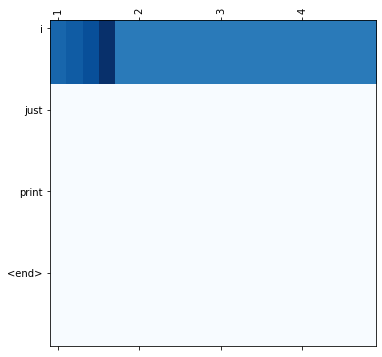

In [64]:
pred,attention=predict('1 2 3 4','dot')
plot_attention(attention,'1 2 3 4',pred)

<font color='blue'>**Calculate BLEU score**</font>

In [66]:
italian = validation['italian'].values[:1000]
english = validation['english_out'].values[:1000]
bleu_score = []

for i in range(1000):
    pred,att = predict(italian[i],'dot')
    bleu_score.append(sentence_bleu(english[i],pred))

print('Bleu Score: ', np.average(bleu_score))

Bleu Score:  1.351865196330822e-231


<font color='blue'>**Repeat the same steps for General scoring function**</font>

In [68]:
model_2 = encoder_decoder(input_len=20, output_len=20, score='general', att_units=256, batch_size=32)
model_2.compile(optimizer=tf.keras.optimizers.Adam(),loss='sparse_categorical_crossentropy')
train_steps_2 = train.shape[0]//1024
valid_steps_2 = validation.shape[0]//1024

model_2.fit(train_dataloader_2, steps_per_epoch=train_steps_2, epochs=25, validation_data=train_dataloader_2, validation_steps=valid_steps_2)

Epoch 1/25


2023-01-24 13:48:10.819064: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:801] function_optimizer failed: Invalid argument: Input 1 of node encoder_decoder_4/decoder_7/while/body/_1/encoder_decoder_4/decoder_7/while/TensorListPushBack_10 was passed float from encoder_decoder_4/decoder_7/while/body/_1/encoder_decoder_4/decoder_7/while/one_step_decoder_8/osd_LSTM/PartitionedCall:7 incompatible with expected variant.
2023-01-24 13:48:10.942013: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:801] layout failed: Out of range: src_output = 30, but num_outputs is only 30
2023-01-24 13:48:11.058775: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:801] function_optimizer failed: Invalid argument: Input 1 of node encoder_decoder_4/decoder_7/while/body/_1/encoder_decoder_4/decoder_7/while/TensorListPushBack_10 was passed float from encoder_decoder_4/decoder_7/while/body/_1/encoder_decoder_4/decoder_7/while/one_step_decoder_8/osd_LSTM/PartitionedCall:7 incompatible with 

279/279 [==============================] - 133s 457ms/step - loss: 2.2350 - val_loss: 2.0873
Epoch 2/25
279/279 [==============================] - 125s 448ms/step - loss: 1.9612 - val_loss: 2.0698
Epoch 3/25
279/279 [==============================] - 125s 448ms/step - loss: 1.9098 - val_loss: 2.0615
Epoch 4/25
279/279 [==============================] - 126s 452ms/step - loss: 1.9059 - val_loss: 2.1039
Epoch 5/25
279/279 [==============================] - 125s 448ms/step - loss: 1.9278 - val_loss: 2.1178
Epoch 6/25
279/279 [==============================] - 126s 451ms/step - loss: 2.0238 - val_loss: 2.1755
Epoch 7/25
279/279 [==============================] - 126s 452ms/step - loss: 1.8825 - val_loss: 2.1850
Epoch 8/25
279/279 [==============================] - 125s 447ms/step - loss: 1.9009 - val_loss: 2.1208
Epoch 9/25
279/279 [==============================] - 126s 450ms/step - loss: 2.0083 - val_loss: 2.1451
Epoch 10/25
279/279 [==============================] - 127s 454ms/step - lo

In [69]:
model_2.summary()

Model: "encoder_decoder_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_6 (Encoder)          multiple                  1652818   
_________________________________________________________________
decoder_7 (Decoder)          multiple                  5399121   
Total params: 7,051,939
Trainable params: 7,051,939
Non-trainable params: 0
_________________________________________________________________


In [70]:
import matplotlib.ticker as ticker
def plot_attention(attention,act,pred):
  #Refer: https://www.tensorflow.org/tutorials/text/nmt_with_attention#translate

  pred,_=predict(act,plot_t2='general')
  plot_att=attention[:len(pred.split(' ')),len(act.split(' '))]
  fig,ax = plt.subplots(figsize=(8,6))
  ax.matshow(attention,cmap='Blues')
  ax.set_xticklabels([''] + act.split(' '), rotation=90)
  ax.set_yticklabels([''] + pred.split(' '))
  plt.show() 
  

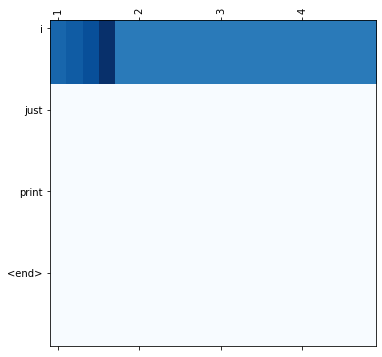

In [71]:
pred,attention=predict('1 2 3 4','general')
plot_attention(attention,'1 2 3 4',pred)

In [72]:
def predict(input_sentence,plot_1):

    token = tknizer_ita.texts_to_sequences([input_sentence])
    pad = pad_sequences(token,maxlen=20,padding='post',truncating='post',dtype='int32')
    encoder_1 = model_1.layers[0].initialize_states(pad.shape[0])
    encoder_ouput_1, encoder_state_h1, encoder_state_c1 = model_1.layers[0](pad, encoder_1)
    init_idx = tknizer_eng.word_index['<start>']
    init_idx = tf.expand_dims([in_indexs],0)
    att = np.zeros((20,20))
    
    pred_sent = []
    for i in range(pad.shape[1]):
    decoder_output, decoder_state_h1, decoder_state_c1, w, cv = model_1.layers[1].onestep_decoder(init_idx, encoder_ouput_1,encoder_state_h1,encoder_state_c1)
    output_1 = model_1.layers[1](init_idx, encoder_ouput_1, encoder_state_h1, encoder_state_c1)
    output_idx = np.argmax(output_1)
    wt = tf.reshape(w,(-1, ))
    att[j] = wt.numpy()
    init_idxs = np.reshape(output_idx,(1,1))
    pred_sent.append(tknizer_eng.index_word[output_idx])
    
    if tknizer_eng.index_word[output_idx]=='<end>':
        break
    return ' '.join(pred_sent), att


In [75]:
italian = validation['italian'].values[:1000]
english = validation['english_out'].values[:1000]
bleu_score = []

for i in range(1000):
    pred,att = predict(italian[i],'general')
    bleu_score.append(sentence_bleu(english[i],pred))

print('Bleu Score: ', np.average(bleu_score))

Bleu Score:  1.590842458919906e-231


<font color='blue'>**Repeat the same steps for Concat scoring function**</font>

In [76]:
model_3 = encoder_decoder(input_len=20, output_len=20, score='concat', att_units=256, batch_size=32)
model_3.compile(optimizer=tf.keras.optimizers.Adam(),loss='sparse_categorical_crossentropy')
train_steps_3 = train.shape[0]//1024
valid_steps_3 = validation.shape[0]//1024

In [77]:
model_3.fit(train_dataloader_3, steps_per_epoch=train_steps_3, epochs=25, validation_data=train_dataloader_3, validation_steps=valid_steps_3)

Epoch 1/25


2023-01-24 14:45:01.170146: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:801] function_optimizer failed: Invalid argument: Input 1 of node encoder_decoder_5/decoder_8/while/body/_1/encoder_decoder_5/decoder_8/while/TensorListPushBack_10 was passed float from encoder_decoder_5/decoder_8/while/body/_1/encoder_decoder_5/decoder_8/while/one_step_decoder_9/osd_LSTM/PartitionedCall:7 incompatible with expected variant.
2023-01-24 14:45:01.302782: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:801] layout failed: Out of range: src_output = 30, but num_outputs is only 30
2023-01-24 14:45:01.427288: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:801] function_optimizer failed: Invalid argument: Input 1 of node encoder_decoder_5/decoder_8/while/body/_1/encoder_decoder_5/decoder_8/while/TensorListPushBack_10 was passed float from encoder_decoder_5/decoder_8/while/body/_1/encoder_decoder_5/decoder_8/while/one_step_decoder_9/osd_LSTM/PartitionedCall:7 incompatible with 

279/279 [==============================] - 139s 477ms/step - loss: 8.5265 - val_loss: 8.4068
Epoch 2/25
279/279 [==============================] - 132s 474ms/step - loss: 8.3051 - val_loss: 8.3689
Epoch 3/25
279/279 [==============================] - 132s 472ms/step - loss: 8.2730 - val_loss: 8.3676
Epoch 4/25
279/279 [==============================] - 132s 474ms/step - loss: 8.2516 - val_loss: 8.4113
Epoch 5/25
279/279 [==============================] - 130s 466ms/step - loss: 8.3320 - val_loss: 8.4037
Epoch 6/25
279/279 [==============================] - 132s 473ms/step - loss: 8.3001 - val_loss: 8.3632
Epoch 7/25
279/279 [==============================] - 132s 472ms/step - loss: 8.2687 - val_loss: 8.3257
Epoch 8/25
279/279 [==============================] - 131s 470ms/step - loss: 8.2337 - val_loss: 8.3284
Epoch 9/25
279/279 [==============================] - 132s 472ms/step - loss: 8.2621 - val_loss: 8.3592
Epoch 10/25
279/279 [==============================] - 131s 470ms/step - lo

In [78]:
model_3.summary()

Model: "encoder_decoder_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_7 (Encoder)          multiple                  1652818   
_________________________________________________________________
decoder_8 (Decoder)          multiple                  5465170   
Total params: 7,117,988
Trainable params: 7,117,988
Non-trainable params: 0
_________________________________________________________________


In [79]:
# ref.: https://github.com/AbhijeetWaghchaure/NLP-Attention-Mechanism/blob/ 
def predict(input_sentence,plot_1):

    token = tknizer_ita.texts_to_sequences([input_sentence])
    pad = pad_sequences(token,maxlen=20,padding='post',truncating='post',dtype='int32')
    encoder_1 = model_1.layers[0].initialize_states(pad.shape[0])
    encoder_ouput_1, encoder_state_h1, encoder_state_c1 = model_1.layers[0](pad, encoder_1)
    init_idx = tknizer_eng.word_index['<start>']
    init_idx = tf.expand_dims([in_indexs],0)
    att = np.zeros((20,20))
    
    pred_sent = []
    for i in range(pad.shape[1]):
    decoder_output, decoder_state_h1, decoder_state_c1, w, cv = model_1.layers[1].onestep_decoder(init_idx, encoder_ouput_1,encoder_state_h1,encoder_state_c1)
    output_1 = model_1.layers[1](init_idx, encoder_ouput_1, encoder_state_h1, encoder_state_c1)
    output_idx = np.argmax(output_1)
    wt = tf.reshape(w,(-1, ))
    att[j] = wt.numpy()
    init_idxs = np.reshape(output_idx,(1,1))
    pred_sent.append(tknizer_eng.index_word[output_idx])
    
    if tknizer_eng.index_word[output_idx]=='<end>':
        break
    return ' '.join(pred_sent), att


In [80]:
import matplotlib.ticker as ticker
def plot_attention(attention,act,pred):
  #Refer: https://www.tensorflow.org/tutorials/text/nmt_with_attention#translate

  pred,_=predict(act,plot_t2='concat')
  plot_att=attention[:len(pred.split(' ')),len(act.split(' '))]
  fig,ax = plt.subplots(figsize=(8,6))
  ax.matshow(attention,cmap='Blues')
  ax.set_xticklabels([''] + act.split(' '), rotation=90)
  ax.set_yticklabels([''] + pred.split(' '))
  plt.show() 
  

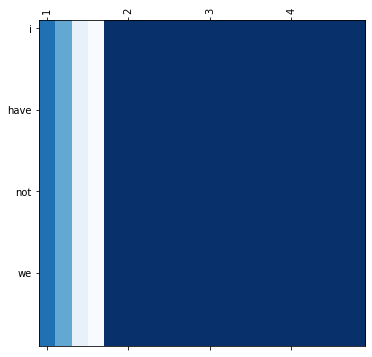

In [81]:
pred,attention=predict('1 2 3 4','concat')
plot_attention(attention,'1 2 3 4',pred)

In [82]:
italian = validation['italian'].values[:1000]
english = validation['english_out'].values[:1000]
bleu_score = []

for i in range(1000):
    pred,att = predict(italian[i],'concat')
    bleu_score.append(sentence_bleu(english[i],pred))

print('Bleu Score: ', np.average(bleu_score))

Bleu Score:  1.1453589005092468e-231


**OBSERVATIONS OF ATTENTION MECHANISM**

In [3]:
from prettytable import PrettyTable
  
# Specify the Column Names while initializing the Table
Table = PrettyTable(["Sr. No.", "Scoring Function", "Bleu Score"])
  
# Add rows
Table.add_row(["1", "DOT", "1.3518"])
Table.add_row(["2", "GENERAL", "1.5908"])
Table.add_row(["3", "CONCAT", "1.1453"])
                     
print(Table)

+---------+------------------+------------+
| Sr. No. | Scoring Function | Bleu Score |
+---------+------------------+------------+
|    1    |       DOT        |   1.3518   |
|    2    |     GENERAL      |   1.5908   |
|    3    |      CONCAT      |   1.1453   |
+---------+------------------+------------+
